In [1]:
from datetime import datetime

import pandas as pd
import numpy as np

import os

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
data_path = './data/stocknet-dataset/price/raw'

fnames = [fname for fname in os.listdir(data_path)]

for fname in fnames[:1]:
  df_raw = pd.read_csv(os.path.join(data_path, fname), index_col='Date').drop('Volume', axis=1)

  df_raw['Open'] = df_raw['Open']/df_raw['Close'] - 1
  df_raw['High'] = df_raw['High']/df_raw['Close'] - 1
  df_raw['Low'] = df_raw['Low']/df_raw['Close'] - 1
  df_raw['Close'] = df_raw['Close']/df_raw['Close'] - 1

  df_raw['d5'] = df_raw['Adj Close'].rolling(5).sum()/(5*df_raw['Adj Close']) - 1
  df_raw['d10'] = df_raw['Adj Close'].rolling(10).sum()/(10*df_raw['Adj Close']) - 1
  df_raw['d15'] = df_raw['Adj Close'].rolling(15).sum()/(15*df_raw['Adj Close']) - 1
  df_raw['d20'] = df_raw['Adj Close'].rolling(20).sum()/(20*df_raw['Adj Close']) - 1
  df_raw['d25'] = df_raw['Adj Close'].rolling(25).sum()/(25*df_raw['Adj Close']) - 1
  df_raw['d30'] = df_raw['Adj Close'].rolling(30).sum()/(30*df_raw['Adj Close']) - 1

  df_raw = df_raw.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Adj Close':'adj_close'}).dropna()

  print(df_raw.shape)

(1229, 11)


In [4]:
df_raw.head()

,open,high,low,close,adj_close,d5,d10,d15,d20,d25,d30
Date,,,,,,,,,,,
2012-10-15,-0.003797,0.000583,-0.017188,0.0,81.931084,-0.001409,0.017652,0.029909,0.047622,0.052630,0.053881
2012-10-16,-0.022192,0.000785,-0.028917,0.0,83.871056,-0.020216,-0.007659,0.003650,0.019379,0.027618,0.028212
2012-10-17,0.006609,0.012690,-0.000946,0.0,83.202446,-0.011194,-0.003849,0.009588,0.023112,0.034313,0.035150
2012-10-18,0.010986,0.014890,-0.004173,0.0,81.657455,0.008950,0.009599,0.023560,0.037248,0.050700,0.052437
2012-10-19,0.034780,0.035960,-0.000361,0.0,78.714554,0.040155,0.040335,0.055569,0.068629,0.084640,0.087925


In [5]:
df_raw.iloc[:,-1].head()

Date
2012-10-15    0.053881
2012-10-16    0.028212
2012-10-17    0.035150
2012-10-18    0.052437
2012-10-19    0.087925
Name: d30, dtype: float64

In [3]:
sample_x = df_raw.iloc[:, :-1].values
sample_y = df_raw.iloc[:, -1].values

In [4]:
import matplotlib.pyplot as plt

from torch.autograd import Variable

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)

        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])

            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())


class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss: ", self.epoch_losses[epoch])

            if epoch % 10 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='upper left')
                plt.show()

            # # Save files in last iterations
            # if epoch == self.epochs - 1:
            #     np.savetxt('../loss.txt', np.array(self.epoch_losses), delimiter=',')
            #     np.savetxt('../y_pred.txt',
            #                np.array(self.y_pred), delimiter=',')
            #     np.savetxt('../y_true.txt',
            #                np.array(self.y_true), delimiter=',')

    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size

        return y_pred

In [9]:
X = sample_x
y = sample_y

batchsize = 128
nhidden_encoder = 128
nhidden_decoder = 128
ntimestep = 10
lr = 0.001
epochs = 5

In [10]:
# dataroot = 'drive/MyDrive/DARNN/data/nasdaq100_padding.csv'
# import numpy as np
# import pandas as pd
# def read_data(input_path, debug=True):
#     """Read nasdaq stocks data.

#     Args:
#         input_path (str): directory to nasdaq dataset.

#     Returns:
#         X (np.ndarray): features.
#         y (np.ndarray): ground truth.

#     """
#     df = pd.read_csv(input_path, nrows=250 if debug else None)
#     # X = df.iloc[:, 0:-1].values
#     X = df.loc[:, [x for x in df.columns.tolist() if x != 'NDX']].values
#     # y = df.iloc[:, -1].values
#     y = np.array(df.NDX)

#     return X, y
# X, y = read_data(dataroot, debug=False)
# batchsize = 128
# nhidden_encoder = 128
# nhidden_decoder = 128
# ntimestep = 10
# lr = 0.001
# epochs = 50

==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...


C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  7  Loss:  0.004437065749828305


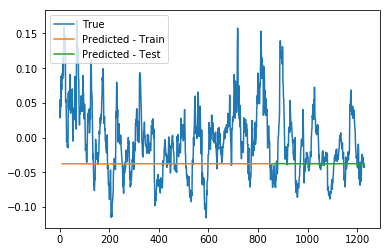

Finished Training


In [11]:
# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
y_pred = model.test()

fig1 = plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.savefig("1.png")
plt.close(fig1)

fig2 = plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.savefig("2.png")
plt.close(fig2)

fig3 = plt.figure()
plt.plot(y_pred, label='Predicted')
plt.plot(model.y[model.train_timesteps:], label="True")
plt.legend(loc='upper left')
plt.savefig("3.png")
plt.close(fig3)
print('Finished Training')

In [12]:
model.test()

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([0.00231852, 0.00234964, 0.00233364, 0.00229988, 0.00225458,
       0.002221  , 0.00223038, 0.00226198, 0.0023064 , 0.00234911,
       0.0023711 , 0.00236796, 0.0023431 , 0.00235688, 0.00233308,
       0.00233351, 0.00232606, 0.0023997 , 0.00248224, 0.00250181,
       0.00253803, 0.00262305, 0.00270875, 0.00284376, 0.00289753,
       0.0029742 , 0.00306237, 0.00319561, 0.00337266, 0.00362607,
       0.0038903 , 0.00412705, 0.00435016, 0.00454368, 0.00469061,
       0.00483137, 0.00495359, 0.00504766, 0.00494235, 0.00473754,
       0.00457918, 0.00444702, 0.00433963, 0.00418824, 0.00400988,
       0.00382994, 0.00365456, 0.00349444, 0.00328327, 0.00297452,
       0.00269534, 0.0025459 , 0.00239614, 0.00232996, 0.00227439,
       0.0022659 , 0.00228804, 0.00234741, 0.00244911, 0.00254424,
       0.00263654, 0.00273416, 0.00278877, 0.002834  , 0.00287418,
       0.00297249, 0.00308774, 0.00318027, 0.00329465, 0.00335795,
       0.00339727, 0.00348753, 0.00354372, 0.00359834, 0.00353

In [13]:
model.test()

C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\pyvenv\venv36\lib\site-packages\ipykernel_launcher.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([0.00231852, 0.00234964, 0.00233364, 0.00229988, 0.00225458,
       0.002221  , 0.00223038, 0.00226198, 0.0023064 , 0.00234911,
       0.0023711 , 0.00236796, 0.0023431 , 0.00235688, 0.00233308,
       0.00233351, 0.00232606, 0.0023997 , 0.00248224, 0.00250181,
       0.00253803, 0.00262305, 0.00270875, 0.00284376, 0.00289753,
       0.0029742 , 0.00306237, 0.00319561, 0.00337266, 0.00362607,
       0.0038903 , 0.00412705, 0.00435016, 0.00454368, 0.00469061,
       0.00483137, 0.00495359, 0.00504766, 0.00494235, 0.00473754,
       0.00457918, 0.00444702, 0.00433963, 0.00418824, 0.00400988,
       0.00382994, 0.00365456, 0.00349444, 0.00328327, 0.00297452,
       0.00269534, 0.0025459 , 0.00239614, 0.00232996, 0.00227439,
       0.0022659 , 0.00228804, 0.00234741, 0.00244911, 0.00254424,
       0.00263654, 0.00273416, 0.00278877, 0.002834  , 0.00287418,
       0.00297249, 0.00308774, 0.00318027, 0.00329465, 0.00335795,
       0.00339727, 0.00348753, 0.00354372, 0.00359834, 0.00353